In [1]:
# setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import tqdm

import random

from PIL import Image
from IPython.display import display

from collections import defaultdict 

import concurrent

In [2]:
#load dataframe

iris_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
iris_df = pd.read_csv(
    iris_url, header=None, 
    names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'])

### Zadanie 0.
Zaimplementuj algorytm K-Means. Postaraj się, żeby implementacja była efektywna, bo będzie on w przyszłości używany do przetwarzania dużych zbiorów danych. Sprawdź działanie zaimplementowanego algorytmu na danych IRIS.

In [3]:
def k_means(data, k, max_iters = 100, max_err_rate=1e-100):
    '''
    returns tuple of group classification and centroids
    '''
    def calc_dists(data, c):
        return -2 * np.dot(data, c.T) + np.array(np.sum(c**2, axis=1))
    
    err_rate = 1+max_err_rate

    # initialize centriods
    c = data[random.sample(range(len(data)), k)]

    iters = 0
    pbar = tqdm.tqdm(total=max_iters, desc='k_means', position=0, leave=True)
    while err_rate > max_err_rate and iters < max_iters:
        pbar.update(1)
        iters += 1
        
        # calculate distances and assign to groups
        dists = calc_dists(data, c)
        groups = dists.argmin(axis=1)

        # update centroids
        counts = np.zeros(k)

        sums = np.zeros((k, len(c[0])))

        for i in range(k):
            assigned_to_ith = groups == i
            counts[i] = len(data[assigned_to_ith])
            sums[i] = np.sum(data[assigned_to_ith], axis=0)

        c_new = sums / np.maximum(counts, np.ones(k))[:,np.newaxis]
        
        err_rate = np.max(np.abs(c - c_new))
        c = c_new
    
    pbar.close()
    return (groups, c)

In [11]:
k_means(np.array(iris_df.iloc[:,:-1]), 3)

k_means:   8%|▊         | 8/100 [00:00<00:00, 2107.29it/s]


(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2]),
 array([[6.85      , 3.07368421, 5.74210526, 2.07105263],
        [5.006     , 3.418     , 1.464     , 0.244     ],
        [5.9016129 , 2.7483871 , 4.39354839, 1.43387097]]))

In [4]:
# draw plots
sns.pairplot(hue='target', data=iris_df)

In [5]:
iris_kmeans_df = iris_df.iloc[:,:-1]
iris_kmeans_df['target'] = list(map(lambda x : str(x) + 'c', k_means(np.array(iris_kmeans_df), 3)[0]))
sns.pairplot(hue='target', data=iris_kmeans_df)

k_means:   6%|▌         | 6/100 [00:00<00:00, 760.27it/s]


### Zadanie 1.
Napisz program, który generuje zbiór N = 5000 losowych wektorów danych z mieszaniny rozkładów gaussowskich o niżej podanych parametrach i sprawdź działanie algorytmu K-Means na tym zbiorze (rozkład Choleskiego macierzy kowariancji można w Matlabie uzyskać poleceniem chol, a w Pythonie poleceniem cholesky).

In [47]:
def generate(N, d, K, p, mi, sigma):
    distributions_ids = random.choices(range(K), k=N, weights=p)
    res = np.random.randn(N, d)

    L = np.linalg.cholesky(sigma)
    
    for i in tqdm.tqdm(range(N), desc='generate', position=0, leave=False):
        res[i, :] = mi[distributions_ids[i], :] + np.dot(L[distributions_ids[i], :, :], res[i, :])
    return np.array(res)

def draw(X, K, dim='2d'):
    if dim == '2d':
        plt.scatter(x=X[:, 0], y=X[:, 1], marker='.')
        plt.figure()
        plt.scatter(x=X[:, 0], y=X[:, 1], c=k_means(X, K)[0], marker='.')
    elif dim == '3d':
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='.')
        
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=k_means(X, K)[0], marker='.')

a) d=2, K=5, p=1/K * 1, μk = 3k * 1, Σk = I (dla k = 1, 2, ..., K)

In [20]:
N, d, K = 5000, 2, 5
p = np.ones(K) / K
mi = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
sigma = np.array([np.eye(d)] * K)

k_means:  36%|███▌      | 36/100 [00:00<00:00, 945.31it/s]


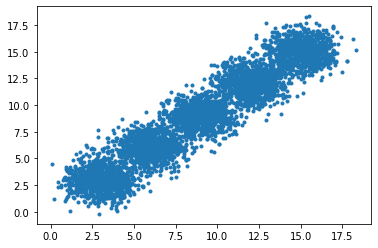

In [8]:
X = generate(N, d, K, p, mi, sigma)
draw(X, K)

b) jak w a), oprócz Σ3 = [30;01]

k_means:   7%|▋         | 7/100 [00:00<00:00, 871.09it/s]


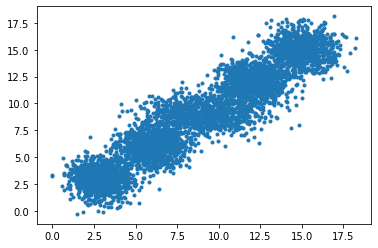

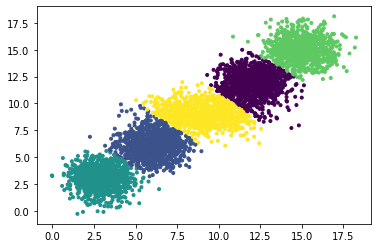

In [21]:
sigma[2, 0] = [3, 0]

X = generate(N, d, K, p, mi, sigma)

draw(X, K)

c) jak w b),oprócz Σ1 = [31;11]

k_means:  19%|█▉        | 19/100 [00:00<00:00, 1114.46it/s]


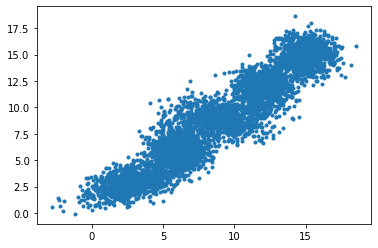

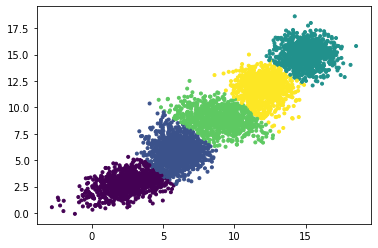

In [22]:
sigma[0, :] = [[3, 1], [1, 1]]

X = generate(N, d, K, p, mi, sigma)

draw(X, K)

d) jak w c), oprócz p = [0.2; 0.1; 0.3; 0.1; 0.3]

k_means:  58%|█████▊    | 58/100 [00:00<00:00, 1142.88it/s]


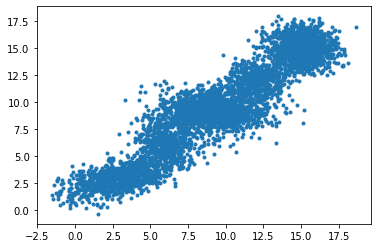

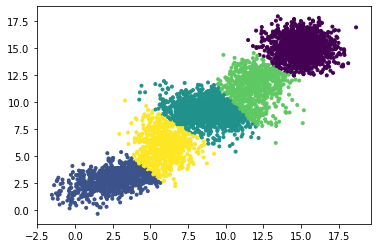

In [23]:
p = [0.2, 0.1, 0.3, 0.1, 0.3]

X = generate(N, d, K, p, mi, sigma)

draw(X, K)

e) jak w a), oprócz d=3 i Σ3 = [310;110;001]

k_means:  18%|█▊        | 18/100 [00:00<00:00, 503.93it/s]


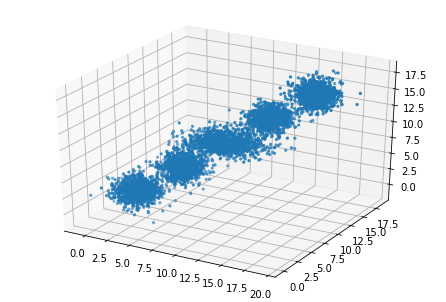

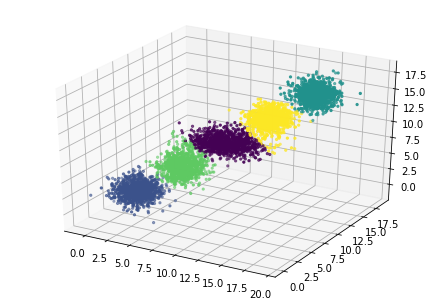

In [23]:
d = 3
mi = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
sigma = np.array([np.eye(d)] * K)
sigma[2, :] = [[3, 1, 1], [1, 1, 0], [0, 0, 1]]

X = generate(N, d, K, p, mi, sigma)
draw(X, K, dim='3d')

f) jak w a), oprócz d = 100 i K = 10.
(1 to wektor odpowiedniej długości złożony z samych jedynek, I to macierz identycznościowa).
Jak pogrupowałbyś te dane, jeśli nie znałbyś wartości K użytej w generatorze?

k_means:  17%|█▋        | 17/100 [00:00<00:00, 193.16it/s]


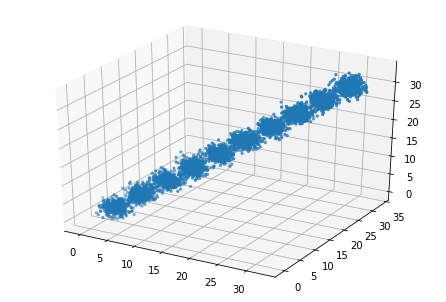

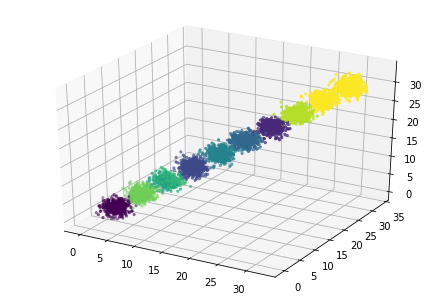

In [24]:
d, K = 100, 10
p = np.ones(K) / K
mi = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
sigma = np.array([np.eye(d)] * K)

X = generate(N, d, K, p, mi, sigma)
draw(X, K, dim='3d')

### Zadanie 2.
Wygeneruj zbiór N = 1000000 losowych danych z d = 1000 wymiarowej mieszaniny K = 1000 rozkładów gaussowskich takiej, że odległość między środkami μk każdych dwóch rozkładów tej mieszaniny jest nie mniejsza niż q = 10. Prawdopodobieństwa wyboru rozkładów mogą być równe, p = 1/K * 1, a same rozkłady mogą mieć nieskorelowane zmienne, Σk = I. Sprawdź działanie algorytmu K-Means na tym zbiorze. Poeksperymentuj z innymi wartościami parametru q.

k_means:   5%|▌         | 5/100 [00:01<00:36,  2.57it/s]       


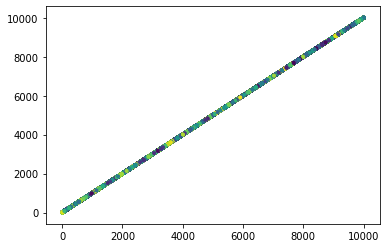

In [53]:
N, d, K, q = 100000, 1000, 1000, 10
p = np.ones(K) / K 
mi = q * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
sigma = np.array([np.eye(d)] * K)
no_batches = 10
for i in range(no_batches):
    X = generate(N//no_batches, d, K, p, mi, sigma)
    plt.scatter(x=X[:, 0], y=X[:, 1], c=k_means(X, K, max_err_rate=1e-100)[0], marker='.')

### Zadanie 3.
W UCI Machine Learning Repository (http://archive.ics.uci.edu/ml/) można znaleźć przykładowe dane do testowania działania algorytmów eksploracji danych. Pobierz 5 zestawów danych (Iris, Wine oraz 3 inne wybrane przez siebie). Zapoznaj się z opisem tych danych. Spróbuj opisać charakterystykę tych danych. Spróbuj przedstawić te dane na wykresach. Sprawdź jak dobrze można je pogrupować za pomocą znanych Ci algorytmów grupowania (sprawdź co najmniej K- Means).

In [76]:
# load dataframes

# wine
wine_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
wine_df = pd.read_csv(wine_url, header=None, 
                      names=['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoi_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315', 'proline'])

# transfusion
# R (Recency - months since last donation), 
# F (Frequency - total number of donation), 
# M (Monetary - total blood donated in c.c.), 
# T (Time - months since first donation), and 
# a binary variable representing whether he/she donated blood in March 2007 (1 stand for donating blood; 0 stands for not donating blood). 
transfusion_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data'
transfusion_df = pd.read_csv(transfusion_url, header=None,
                            names=['since_last', '#donations', 'blood_donated', 'since_first', 'donated_03.07']).iloc[1:,:]


# banknote authentication
# 1. variance of Wavelet Transformed image (continuous) 
# 2. skewness of Wavelet Transformed image (continuous) 
# 3. curtosis of Wavelet Transformed image (continuous) 
# 4. entropy of image (continuous) 
# 5. class (integer) 
banknote_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
banknote_df = pd.read_csv(banknote_url, header=None,
                            names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])


# reviews
reviews_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00484/tripadvisor_review.csv'
reviews_df = pd.read_csv(reviews_url, header=None,
                         names=['id', 'art_galleries', 'clubs', 'bars', 'restaurants', 'museums', 'resorts', 'parks', 'beaches', 'theaters', 'religious']).iloc[1:, 1:]

k_means:   4%|▍         | 4/100 [00:00<00:00, 190.59it/s]


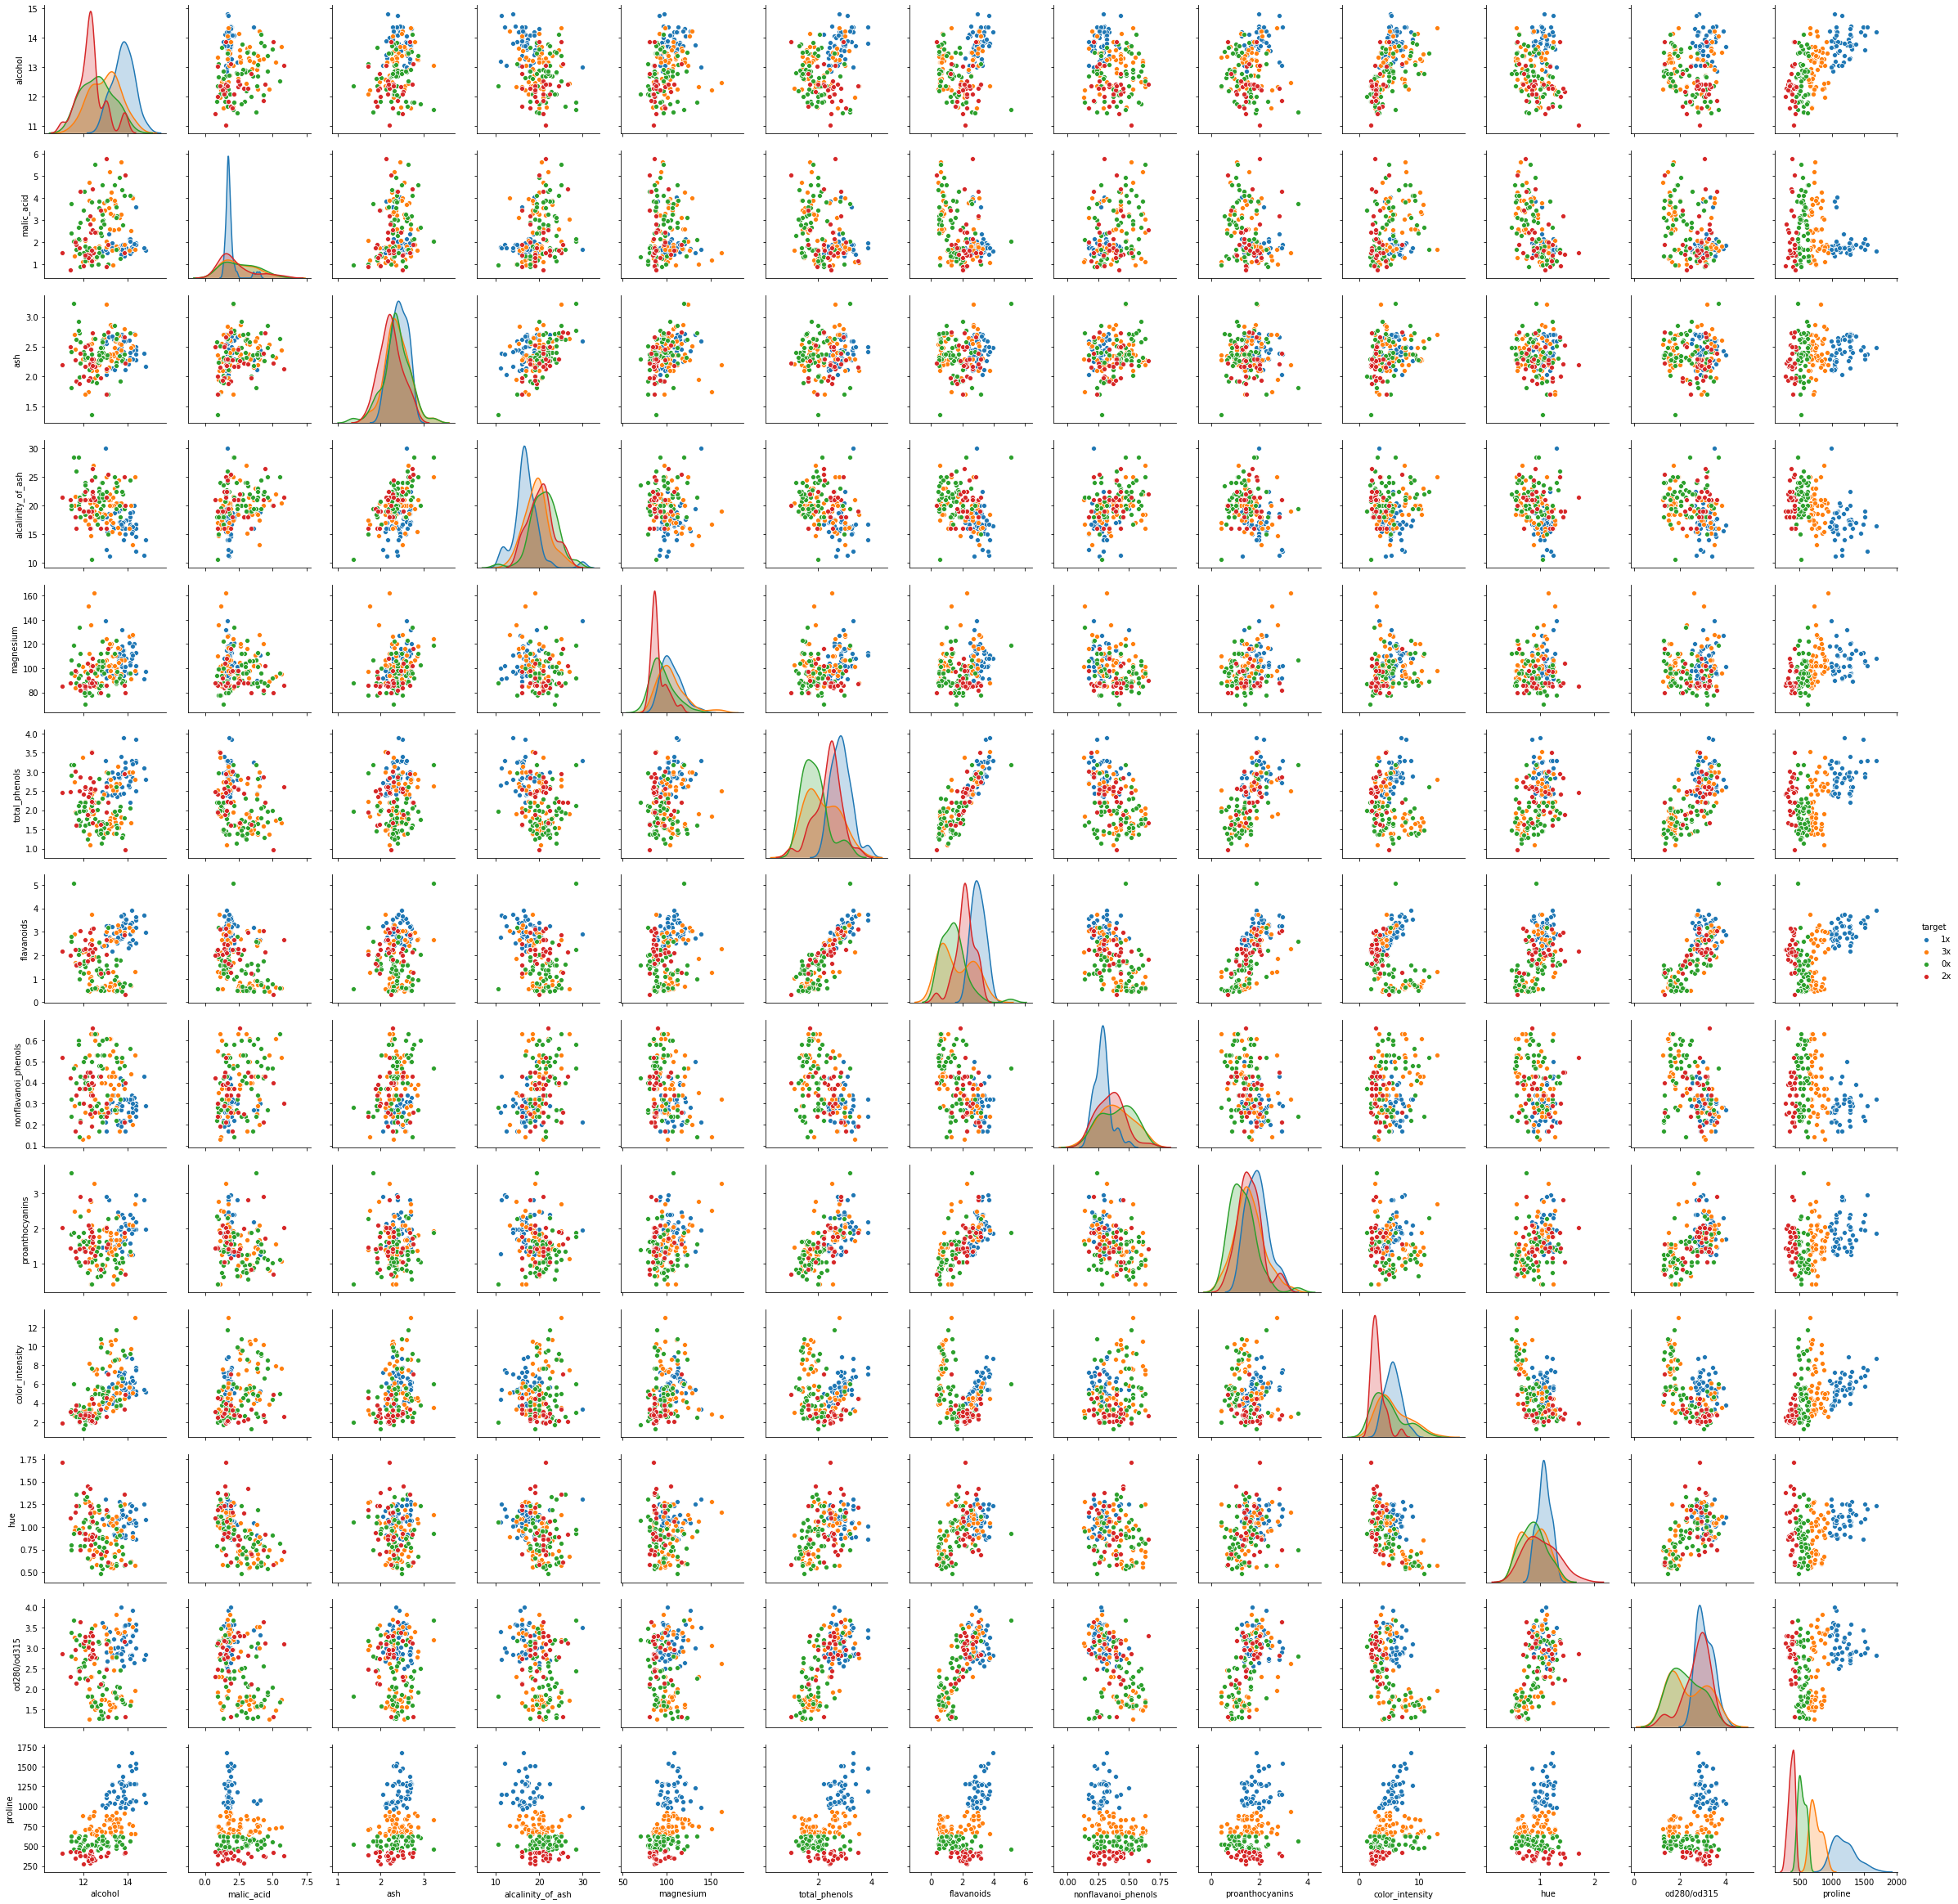

In [18]:
groups, _ = k_means(np.array(wine_df), 5)
wine_kmeans_df = wine_df.copy()
wine_kmeans_df['target'] = list(map(lambda x : str(x) + 'x', groups))
sns.pairplot(wine_kmeans_df, hue='target')

In [77]:
groups, _ = k_means(np.array(transfusion_df, dtype=float), 3)
transfusion_kmeans_df = transfusion_df.copy()
transfusion_kmeans_df['target'] = list(map(lambda x : str(x) + 'x', groups))
sns.pairplot(transfusion_kmeans_df, hue='target')

k_means:   4%|▍         | 4/100 [00:00<00:00, 261.04it/s]


k_means:  16%|█▌        | 16/100 [00:00<00:00, 211.48it/s]


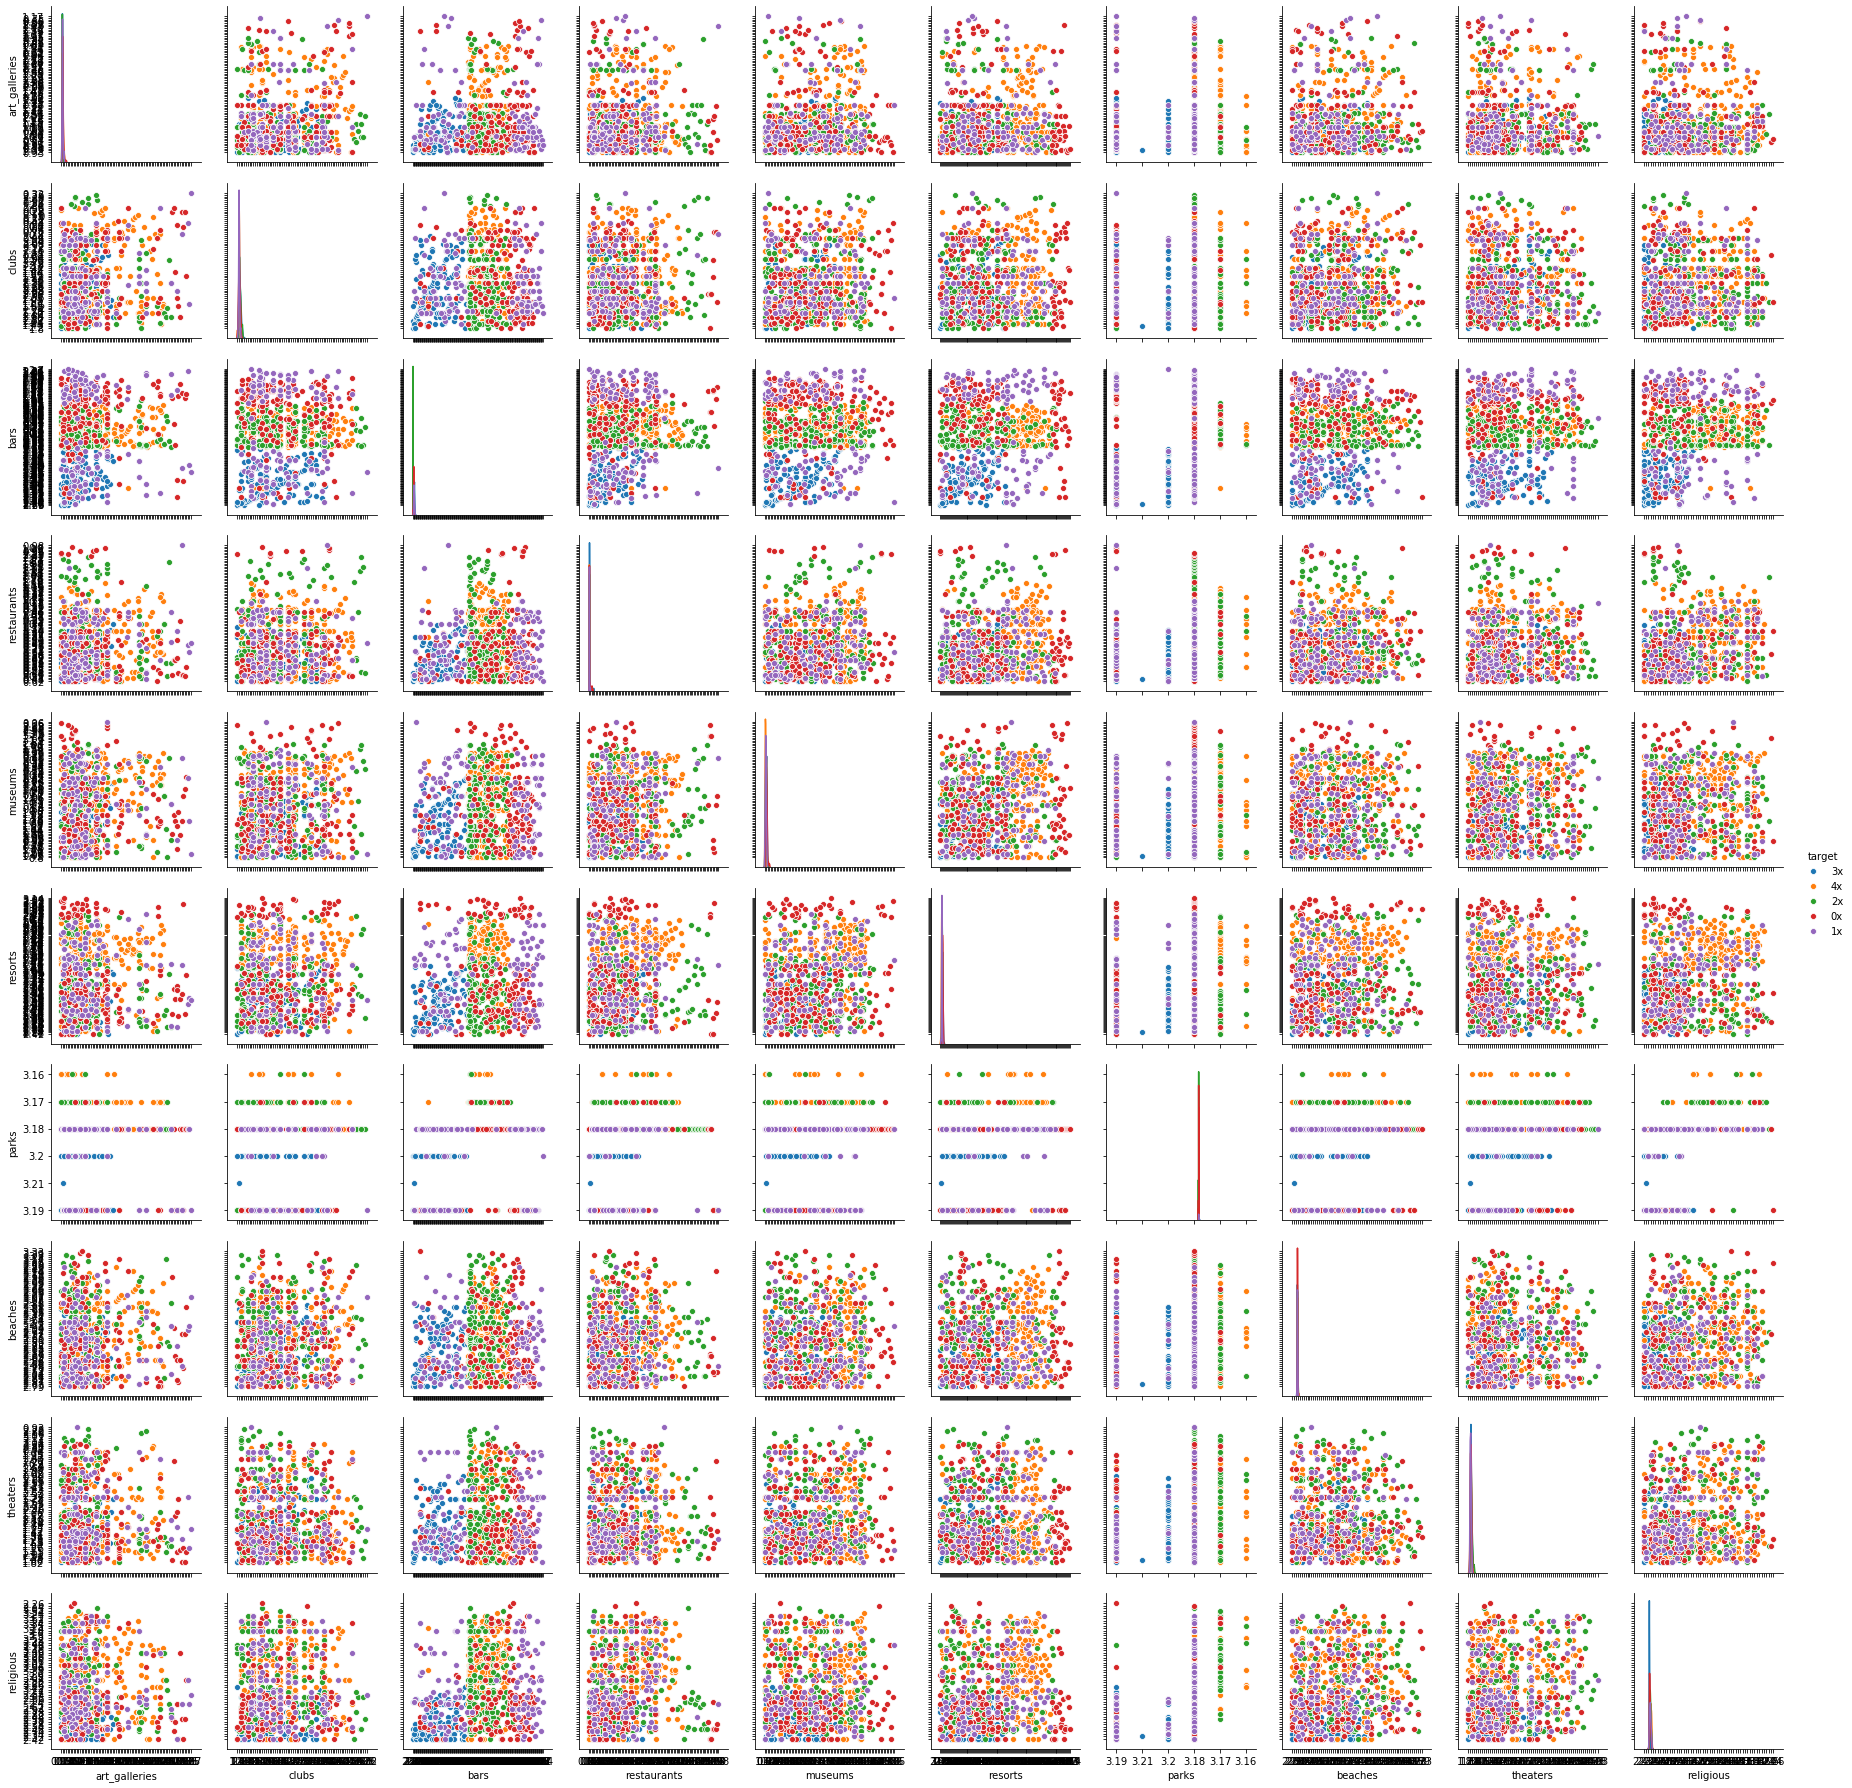

In [16]:
groups, _ = k_means(np.array(reviews_df, dtype=float), 5)
reviews_kmeans_df = reviews_df.copy()
reviews_kmeans_df['target'] = list(map(lambda x : str(x) + 'x', groups))
sns.pairplot(reviews_kmeans_df, hue='target')

k_means:  10%|█         | 10/100 [00:00<00:00, 122.88it/s]


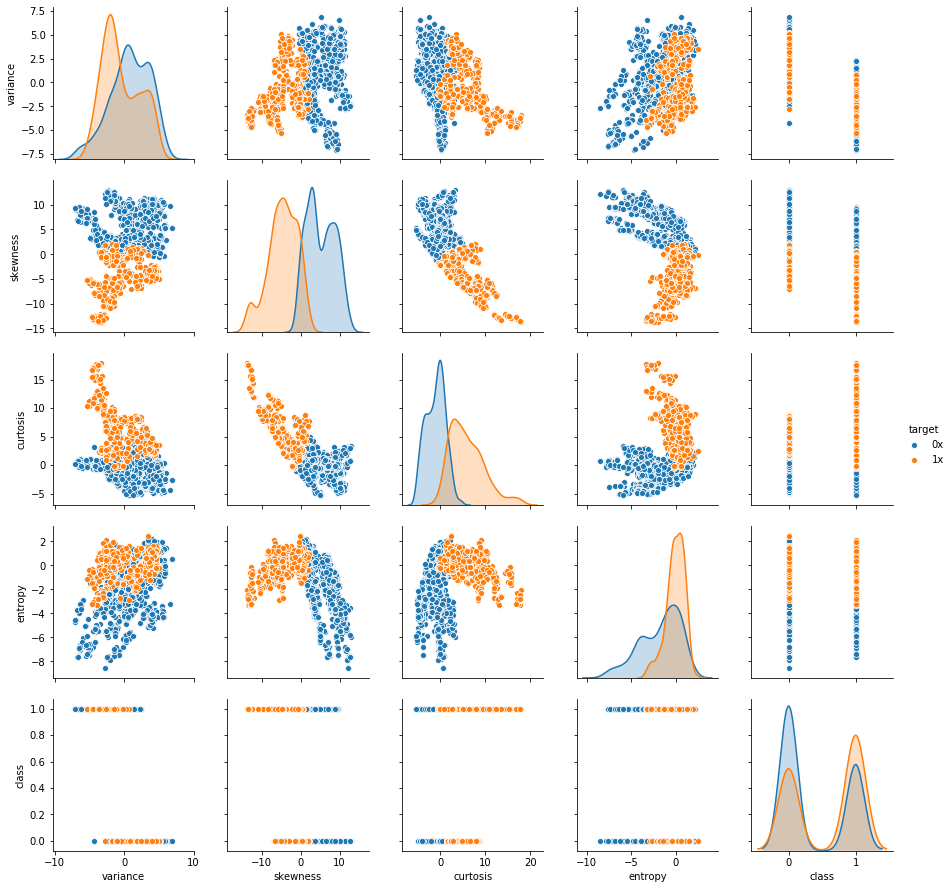

In [48]:
groups, _ = k_means(np.array(banknote_df, dtype=float), 2)
banknote_kmeans_df = banknote_df.copy()
banknote_kmeans_df['target'] = list(map(lambda x : str(x) + 'x', groups))
sns.pairplot(banknote_kmeans_df, hue='target')

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


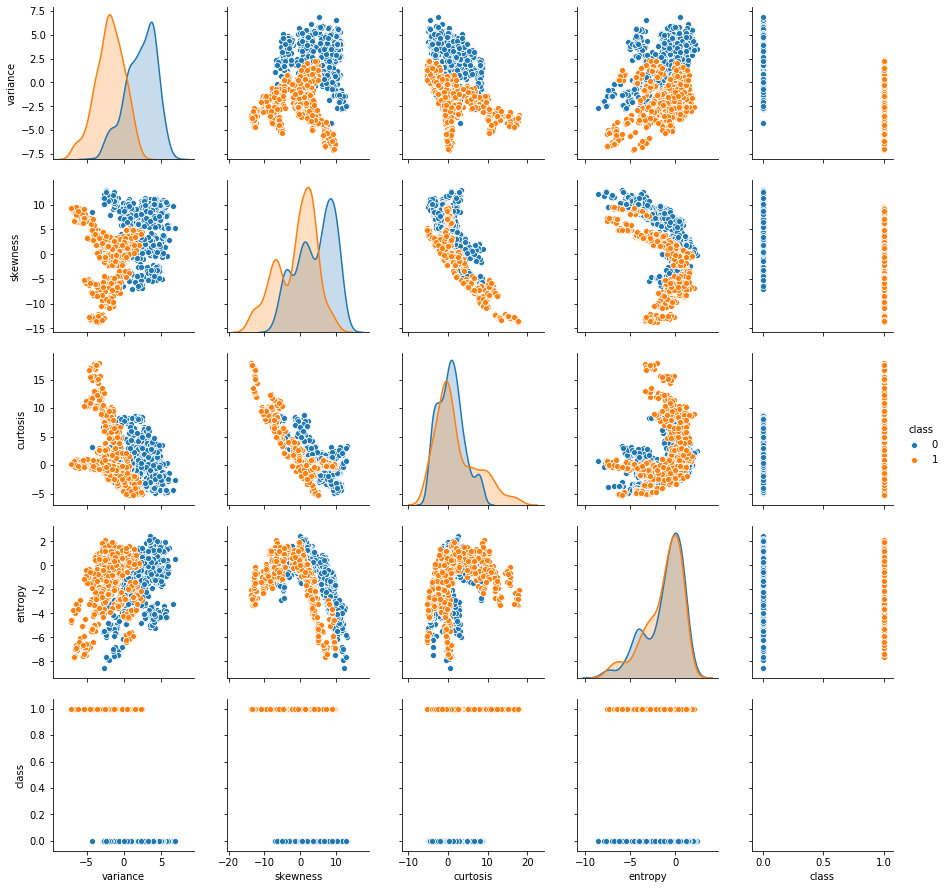

In [80]:
sns.pairplot(banknote_df, hue='class')

### Zadanie 4.
Zdjęcie fotograficzne o rozdzielczości A x B w formacie RGB można traktować jako zbiór N = A * B trójwymiarowych punktów danych. Po przeprowadzeniu grupowania takich danych, z liczbą grup K, można obniżyć liczbę kolorów zdjęcia do K (tworząc paletę K kolorów określonych przez środki uzyskanych grup, a następnie zastępując kolor każdego piksela najbliższym mu kolorem ze stworzonej palety). Napisz program wczytujący zdjęcie z pliku JPG (polecenie imread w Matlabie lub w Pythonie), redukujący liczbę kolorów w powyższy sposób i wyświetlający zredukowane zdjęcie na ekranie. Sprawdź działanie programu na 5 wybranych przez siebie zdjęciach.

In [4]:
paths = ['img/coffee-resized.jpg', 'img/leniwce.jpg', 'img/spacex.jpg', 'img/tecza.jpg', 'img/piast.jpg']

def reduce_colors(path, k, max_iters=None):
    img = np.array(Image.open(path))
    display(Image.open(path))
    if max_iters is None:
        group_class, colors = k_means(img.reshape(img.shape[0] * img.shape[1], img.shape[2]), k)
    else:
        group_class, colors = k_means(img.reshape(img.shape[0] * img.shape[1], img.shape[2]), k, max_iters=max_iters)
        
    train = img.copy().reshape(img.shape[0] * img.shape[1], img.shape[2])
    
    for i in range(k):
        train[group_class == i] = colors[i]
        
    train = train.reshape(img.shape)
    display(Image.fromarray(train, 'RGB'))

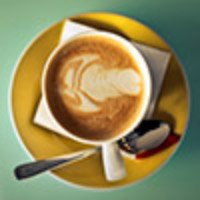

k_means:  57%|█████▋    | 57/100 [00:00<00:00, 92.98it/s]


In [6]:
k = 10
reduce_colors(paths[0], k)

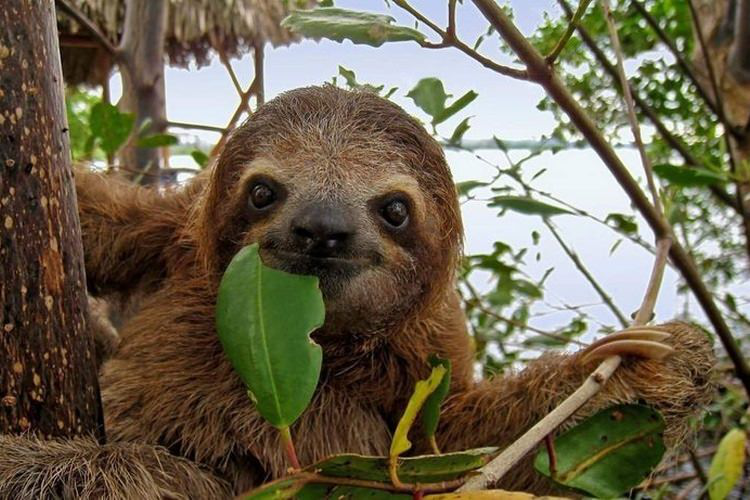

k_means: 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


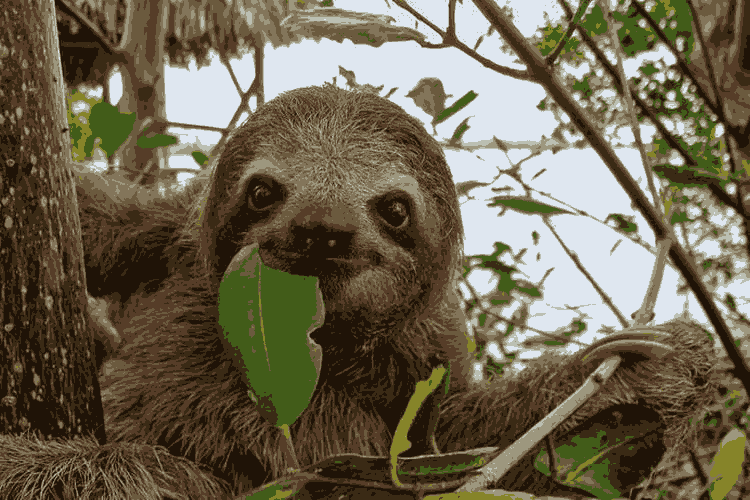

In [33]:
reduce_colors(paths[1], k, 50)

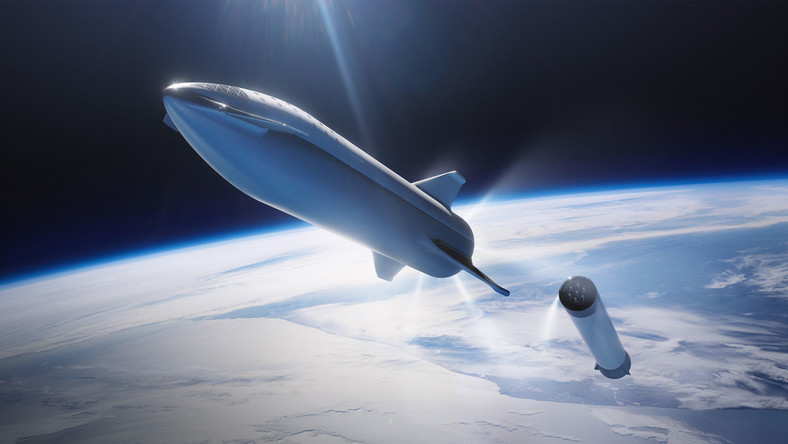

k_means: 100%|██████████| 2/2 [00:00<00:00, 10.75it/s]


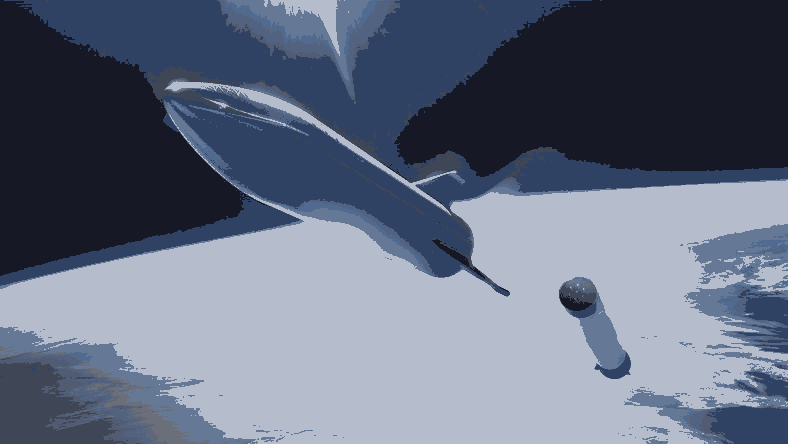

In [8]:
reduce_colors(paths[2], k, 2)

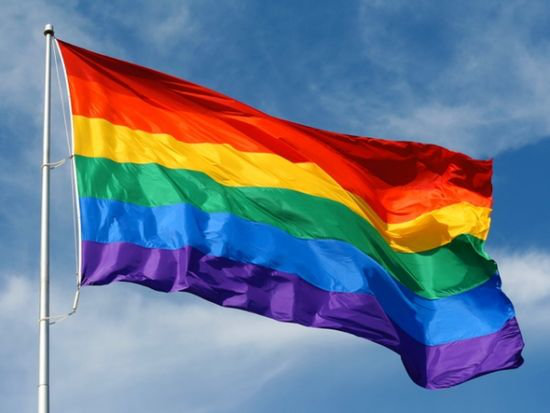

k_means: 100%|██████████| 2/2 [00:00<00:00, 16.32it/s]


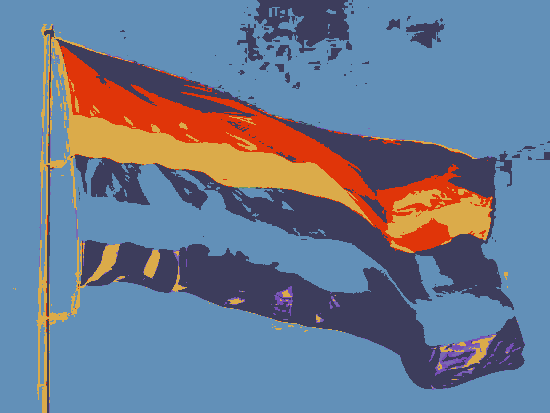

In [10]:
reduce_colors(paths[3], k, 2)

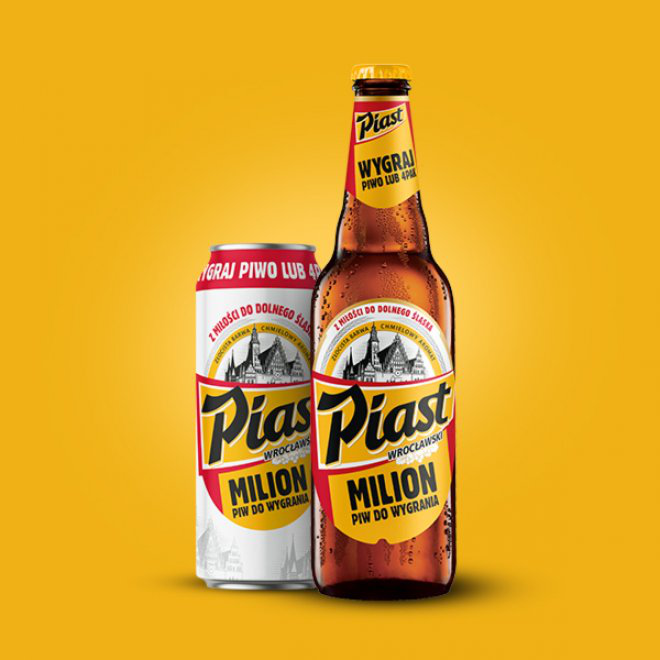

k_means: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s]


In [12]:
reduce_colors(paths[4], 5, 2)

### Zadanie 5.
Zbiór danych Kosarak (stworzony przez Ferenca Bodona, dostępny m.in. na http://fimi.ua.ac.be/data/kosarak.dat.gz) zawiera informacje o transakcjach zawartych w sieci supermarketów. Każdy wiersz tego pliku reprezentuje jedną transakcję i zawiera identyfikatory produktów kupionych w tej transakcji.

a) Wyznacz T = 1000 najczęściej kupowanych produktów (tzn. produktów, które pojawiły się w największej liczbie transakcji). Oznaczmy je kolejno Z1, Z2, ..., ZT.

b) Dla każdego produktu, policz ile razy był on kupowany razem z produktem Zi (dla i =1, 2, ..., T) tworząc w ten sposób wektor liczbowy p = (p1, p2, ..., pT) opisujący dany produkt.

c) Pogrupuj produkty używając ich powyższej reprezentacji oraz algorytmu K-Means z różną liczbą grup (poeksperymentuj).

Przedstaw wyniki swoich eksperymentów. Możesz także poeksperymentować z parametrem T. Które grupy produktów można uznać za szczególnie istotne, a które za raczej przypadkowe?

In [2]:
kosarak_df = pd.read_csv('http://fimi.ua.ac.be/data/kosarak.dat.gz')

In [3]:
# count how many times each was bought
count_bought = defaultdict(int)
T = 1000

for row in kosarak_df.values:
    for v in row[0].split():
        count_bought[v] += 1
count_bought = dict(sorted(count_bought.items(), key=lambda kv: kv[1], reverse=True))
Z = list(count_bought.keys())[:T]

In [4]:
bought_with_t = np.zeros((len(count_bought)+1, T))

for row in tqdm.tqdm(kosarak_df.values, position=0, leave=False):
    bought = row[0].split()
    bought_in_Z_idx = [Z.index(prod) for prod in bought if prod in Z]

    for b in bought:
        b = int(b)
        bought_with_t[b][bought_in_Z_idx] += 1

In [41]:
KMEANS = [(k, k_means(bought_with_t, k)) for k in [3, 5, 7]]

k_means:  54%|█████▍    | 54/100 [00:21<00:18,  2.49it/s]


K-MEANS FOR VECTOR LENGHT


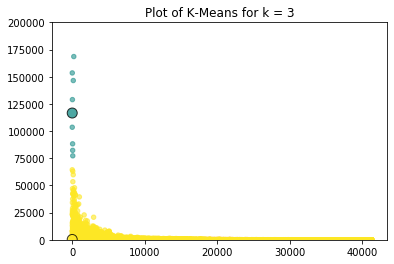

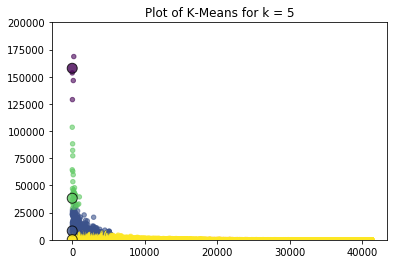

In [44]:
def draw_kosarak_vec_len(data, KMEANS, show_fragment=False):
    def draw_kmeans(data, kmeans, k):
        '''
        draws plot where:
            - x is an index,
            - y is length of vector
        '''
        def length(data):
            return np.sqrt(np.sum(data ** 2, axis=1))
        
        groups, centroids = kmeans

        plt.figure()
        if show_fragment:
            plt.ylim(0, 200000)
        plt.title(f'Plot of K-Means for k = {k}')

        plt.scatter(x=np.arange(len(data)), y=length(data), s=20, alpha=0.6, c=groups)
        plt.scatter(x=np.arange(len(centroids)), y=length(centroids), s=100, alpha=0.8, c=range(k), edgecolor='black')
    
    print('K-MEANS FOR VECTOR LENGHT')
    for k, kmeans in KMEANS:
        draw_kmeans(data, kmeans, k)

draw_kosarak_vec_len(bought_with_t, KMEANS, show_fragment=True)

K-MEANS FOR 2 MOST BOUGHT WITH


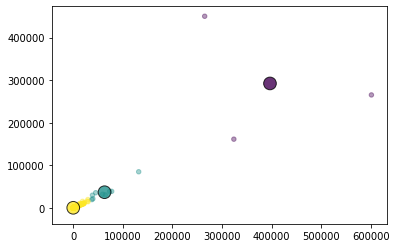

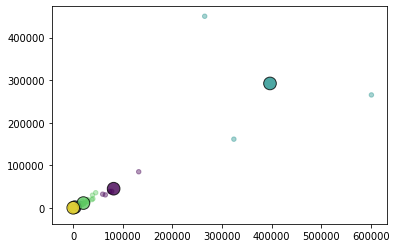

In [54]:
def draw_kosarak_2_most(data, KMEANS, show_fragment=False):
    def draw_kmeans(data, kmeans, k):
        '''
        draws plot where:
            - x is # of bought with first most popular, 
            - y is # of bought with second most popular
        '''
        
        groups, centroids = kmeans
        
        plt.figure()
        
        if show_fragment:
            plt.xlim(0, 30000)
            plt.ylim(0, 30000)
        
        plt.scatter(x=data[:, 0], y=data[:, 1], s = 20, alpha=0.4, c=groups)
        plt.scatter(x=centroids[:, 0], y=centroids[:, 1], s = 160, alpha=0.8, c=np.arange(k), edgecolor='black')
        
    
    print('K-MEANS FOR 2 MOST BOUGHT WITH')
    for k, kmeans in KMEANS:
        draw_kmeans(data, kmeans, k)
        
draw_kosarak_2_most(bought_with_t, KMEANS, show_fragment=False)